# Literature analysis with n-grams

As you probably know from your English homeworks, comparing two works of fiction can be a very hard and time-consuming task.
It would be much nicer if we could just have the computer do all the work.
But how could that work?

One simple idea is that an author's style is represented by which words (s)he uses, and in particular which words (s)he uses most.
Words are also known as *unigrams*.
This is in contrast to *bigrams*, which consist of two words, *trigrams* (three words), and so on.
For instance, the sentence

    John likes Mary and Peter
    
contains the unigrams

    John, likes, Mary, and, Peter
    
the bigrams

    John likes, likes Mary, Mary and, and Peter
    
and the trigrams

    John likes Mary, likes Mary and, Mary and Peter
    
We could also have 4-grams, 5-grams, or 127-grams.
Quite generally, a model that is based on words or sequences of words is called an *n-gram model*.
So if we want to analyze an author's style in terms of their word usage, we are proposing a unigram model of stylistic analysis.

But does a unigram model actually work?
Well, let's put the idea to the test: we will compare William Shakespeare's *Hamlet* and Christopher Marlowe's *The Tragical History of Dr. Faustus* using this technique.
If we find something interesting, then unigram models might be worthwhile after all.

# Getting the files

First we need to have *Hamlet* and *Faustus* in some digital format that we can feed into Python.
We want this to be a plaintext format, i.e. the pure text without any layout.
We can use Python to download those files from [Project Gutenberg](https://www.gutenberg.org/).

In [1]:
import urllib.request
urllib.request.urlretrieve("http://www.gutenberg.org/cache/epub/1524/pg1524.html", "hamlet.txt")
urllib.request.urlretrieve("http://www.gutenberg.org/cache/epub/811/pg811.txt", "faustus.txt")

('faustus.txt', <http.client.HTTPMessage at 0x10a1bd5f8>)

Running the code above should have put two files in the folder you are running this notebook from: `hamlet.txt` and `faustus.txt`.
Open them with a text editor, for example Notepad if you are using a Windows computer.
Scroll up and down a bit to get a better idea of what the files look like.
Write down a list of the things that stand out to you.
In particular:

1. Do the two files look the same, or are there major differences?
1. Do the files just contain the text of the plays, or also additional information (check the top and bottom of each file carefully)?
1. If we want just the words used by the protagonists of the plays, what changes need to made to the files?

# Cleaning up the files

## Analysis

You should have noticed quite a few problems with the files, only some of which we can fix by hand.

1. While `faustus.txt` is fairly easy to read, `hamlet.txt` is cluttered with all kinds of weird code like `<p id="id00057">` and `<br/>`. That's because we downloaded a textfile for `faustus.txt`,  but an html-file for `hamlet.txt`. The expressions between `<` and `>` are html-markup, which is needed to display a file in a webbrowser.

1. Both files start with information about Project Gutenberg, which we do not want.

1. Both files have information at the end that is not part of the play. In `hamlet.txt`, it's just a disclaimer that the play is over, whereas `faustus.txt` is full of footnotes.

1. In `faustus.txt`, the text is often interrupted by strings like `[17]`. Those are references to footnotes.

1. The files use different formats to indicate who is speaking.
    - In `hamlet.txt`, names are abbreviated and occur between the markup `<p id="id...">` and `<br/>`.
    - In `faustus.txt`, names are fully capitalized.
    
1. Both files put stage instructions between square brackets, for example `[Francisco at his post. Enter to him Bernardo.]`.

1. In `faustus.txt`, stage instructions are also indicated by indentation.

1. In `faustus.txt`, all dialog is indented, but less so than the stage instructions.
    
1. Both files contain many empty lines.

1. Both files capitalize words at the beginning of a new line.

These are all problematic for us:

- We just want to be able to see which words are used in each play, and how often each word is used.
- We do not want HTML markup, information about Project Gutenberg, footnotes, or empty lines.
- We also do not want to keep track of names if they just indicate who is speaking. That's not part of the play as such.
- We should also exclude stage instructions because those do not belong to the literary part of the play either.

Fixing all these things by hand would be tons of work.
Fortunately, we only need to delete a few things by hand, while Python can do the rest.

## Clean-up

Let's first do the manual fixes:

1. Open `hamlet.txt` and delete the first 362 lines. That's everything before the line `<h5 id="id00059">SCENE. Elsinore.</h5>`gt

1. Now go to the end of `hamlet.txt` and delete the last 7 lines. That's everything after and including the line `<p id="id01465"> style="margin-top: 5em">The End of Project Gutenberg Etext of Hamlet by Shakespeare<br />`.

1. Open `faustus.txt` and delete the first 139 lines. That's everything up to and including the line `FROM THE QUARTO OF 1616.`

1. In the same file, delete everything after the line `Terminat hora diem; terminat auctor opus.`
   Use the editor's search function to find it quickly.

Alright, now we have removed quite a bit of unwanted stuff from the files, but there's still many problems with the formatting.
The Python code below will fix all of those for us.

In [ ]:
# regular expressions; still to be done

After running the code, open the files `hamlet_clean.txt` and `faustus_clean.txt` in your text editor.
All the unwanted annotations, markup and stage instructions are gone, and we have a much cleaner file now.
Cleaning up files isn't too much fun, but it is really necessary.
Always remember the old saying: **garbage in, garbage out!**
We have to make sure our data is a clean as possible in order to do a good analysis.
But now we can finally get started on the fun part!

# Tokenization

Remember that we are interested in determining which words each author uses, and how often they do so.
As far as Python is concerned, our text files are just a very long string of random characters.
Python has no understanding of what a word is, so it cannot count words without our help.
What we need to do is to tell Python how it can convert a string into a list of words.
For example, the string

    John likes John, Bill's mother, and Sue.

should be converted to the list

    ["John", "likes", "John", ",", "Bill", "'s", "mother", ",", "and", "Sue", "."]
    
Notice that the list may contain duplicates --- reading the list from left to right must give us the original sentence without any omissions.
Also, punctuation is still included, but each punctuation mark is treated like an individual word.
    
This process of converting a string to a list is called *tokenization*.
A *tokenizer* is a function that reads in a string and returns the corresponding list.
So your first job is to write a function that reads in a whole play as a string and then returns the tokenized list.

In [40]:
# A few hints for writing a tokenizer:
#
# 1) You need to load the file first obviously;
#    but I suggest that you also take a look at the corresponding strings;
#    you will encounter a few surprises, in particular many instances of \n
#
# 2) For the purpose of tokenization, the following things are words:
#    - punctuation symbols (! ? . , ; :)
#    - a hyphen (-) if it is surrounded by white space; but in words like laurel-bough, the - is not a word
#    - 's, both as a possessive marker (John's mother) and as a shortened form of is (it's, there's)
#    - any string of characters between whitespace or punctuation symbols
#    - whitespace refers to a space, but also to the special characters \t (tab) and \n (new line)
#
# 3) I suggest you iterate over the positions in the string with a for-loop.
#    Save the last position that was a punctuation symbol or whitespace.
#    If you encounter another punctuation symbol or whitespace,
#    the string between this current position and the previously saved one is a word.
#    But careful: the apostrophe complicates things a bit.

# Tokenize hamlet
hamlet = open("hamlet_clean.txt", 'r')
faustus = open("faustus_clean.txt", 'r')

# Pull out the words of hamlet
hamlet_tokenized = []
for line in hamlet:
    if line[:-1]:  # This says if the line (minus the new line character at the end) has
                   # anything in it, then its true and we will do the code inside the if
        hamlet_tokenized = hamlet_tokenized + line.split()
        
# Pull out the words of hamlet
faustus_tokenized = []
for line in faustus:
    if line[:-1]:  # This says if the line (minus the new line character at the end) has
                   # anything in it, then its true and we will do the code inside the if
        faustus_tokenized = faustus_tokenized + line.split()

# Always clean up
hamlet.close()
faustus.close()

# Converting the tokenized list to a dictionary

A tokenized list is nice, but not enough.
We also want to know how often each word is used.
We can do this with a dictionary where the keys are words and the values indicate how often the word occurs in the tokenized list.
For example, the list

    ["John", "likes", "John", ",", "Bill", "'s", "mother", ",", "and", "Sue", "."]
    
should be converted to the dictionary

    {"John": 2, "likes": 1, ",": 2, "Bill": 1, "'s": 1, "mother": 1, "and": 1, "Sue": 1, ".": 1}

In [41]:
# Write a function that converts the tokenized lists to dictionaries
# 
# Pro-tip: Python has a special subtype of dictionaries called Counters, which are perfect for this task.
#          So if you want, you can use a Counter instead of a dictionary.
#          Google around a bit to see how they work.

# This is almost just a single line where we cast our list to a Counter data structure
from collections import Counter

hamlet_counted = Counter(hamlet_tokenized)
faustus_counted = Counter(faustus_tokenized)

# Analyzing the dictionaries

## Our first attempt...

Alright, now we finally have word counts for both plays.
But what are we supposed to do with them?
The dictionaries are way too large to compare by hand.
Well, we could first compare the ten most common words in each dictionary.

In [42]:
# Here's a nice helper function
def dict_to_ordered_list(dictionary):
    """convert dictionary to list of keys, ordered by decreasing value"""
    # key=dictionary.get uses the values for sorting
    # reverse=True sorts the list in descending order rather than ascending
    return sorted(dictionary, key=dictionary.get, reverse=True)

In [43]:
# Your turn! Use the helper function to look at the ten most common words in each play.
sorted_hamlet = dict_to_ordered_list(hamlet_counted)
sorted_faustus = dict_to_ordered_list(faustus_counted)

print("Hamlet's 10 most common words:")
for i in range(10):
    print(sorted_hamlet[i])
    
print("\nFaustus's 10 most common words:")
for i in range(10):
    print(sorted_faustus[i])

Hamlet's 10 most common words:
<p
</p>
the
and
of
to
I
a
my
in

Faustus's 10 most common words:
the
and
of
I
to
a
in
And
FAUSTUS.
my


## ...is a failure

Well that output isn't very helpful, it's all just useless words like *a* and *the* and *to*.
But that's actually expected.
Remember what you learned about **Zipf's law**: a handful of words make up over 50% of all words in a text.
Looking at the ten most common words in each play can't reveal much because Zipf's law already tells us that those words won't be interesting.
If we want to find anything of interest, we have to ignore these common but uninteresting words, which are also called *stop words*.

In [13]:
# Okay, time to deal with stop words:
#
# 1) Download the file from
#    https://raw.githubusercontent.com/stanfordnlp/CoreNLP/master/data/edu/stanford/nlp/patterns/surface/stopwords.txt
# 2) Each line of the file contains a stop word.
#    Read in the file and convert it to a list of stop words.
# 3) Use this list to look at the ten most common words in each play that are not stop words.
#
#
# Pro-tip: Step 3 can be done with a single line of code using a Python list comprehension;
#          if you're curious, ask your tutor or google around a bit


# This will download the text from the URL
urllib.request.urlretrieve("https://raw.githubusercontent.com/stanfordnlp/CoreNLP/master/data/edu/stanford/nlp/patterns/surface/stopwords.txt", 
                           "stopwords.txt")

# This reads the words from stopwords.txt in and stores them in a list
stop_list = []
input_file = open("stopwords.txt", "r")
for line in input_file:
    stop_list.append(line[:-1]) # -1 to get rid of new line characters

# Plotting the data

Now we have a rough idea which words are the most common in each play, and a few differences already show up at this point.
But that's not the only thing we could look at.
Maybe one author is much less creative in their choice of words than the other.
Then we would expect that the uncreative author uses the same words over and over, whereas the creative one avoids repetitions.

We can rephrase this idea as a problem of relative frequency: how frequent are words relative to other words in the text?
And this can be represented as a graph where words are placed along the x-axis and the y-axis indicates for each word how often it occurs.
When the words are ordered by frequency, a creative author should produce a graph with a very long tail --- that is to say, there's many, many words with very low frequency.
An uncreative author, on the other hand, should have a small stock of words that occur over and over and a comparatively shorter tail.

We can use Python's *matplotlib* package to produce such graphs for us.
Matplotlib will take the dictionaries as input with keys for the x-axis and values for the y-axis.
But recall that our dictionaries still contain the unwanted stop words.
We need to fix this first.

In [45]:
def dict_without_stopwords(dictionary, stopword_list):
    """remove stop words from dictionary"""
    
    # some magic happens here
    clean_dictionary = {}
    
    for key in dictionary.keys():
        if key.lower() not in stopword_list:        # lower() because all stopwords are lower case
            clean_dictionary[key] = dictionary[key]
    
    return clean_dictionary

In [47]:
# Get rid of stop words
nonstop_hamlet = dict_without_stopwords(hamlet_counted, stop_list)
nonstop_faustus = dict_without_stopwords(faustus_counted, stop_list)

# Turn dictionary into sorted list using old function
sorted_nonstop_hamlet = dict_to_ordered_list(nonstop_hamlet)
sorted_nonstop_faustus = dict_to_ordered_list(nonstop_faustus)

print("Hamlet's top 10 non-stop words:")
for i in range(10):
    print(sorted_nonstop_hamlet[i])
    
print("\nFaustus' top 10 non-stop words:")
for i in range(10):
    print(sorted_nonstop_faustus[i])

Hamlet's top 10 non-stop words:
<p
</p>
will
shall
thou
thy
lord,
like
good
let

Faustus' top 10 non-stop words:
FAUSTUS.
thou
Faustus,
will
MEPHIST.
shall
thy
O,
Faustus
Enter


Now we can finally look at the graphs for *Hamlet* and *Dr. Faustus*.

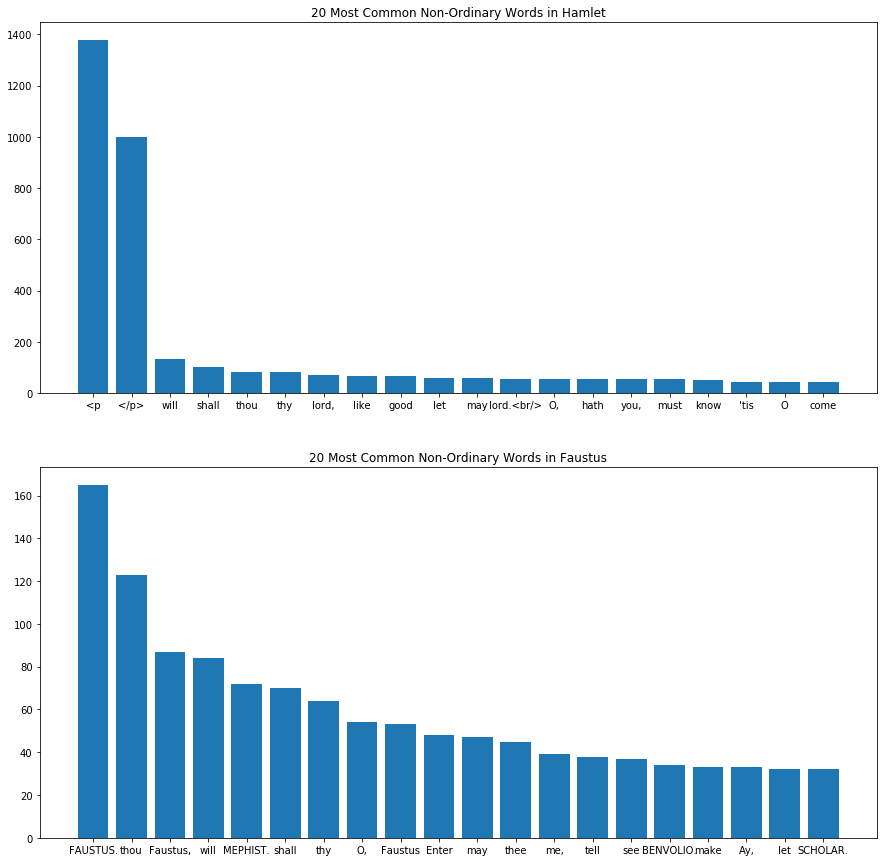

In [59]:
# Now to plot
import matplotlib.pyplot as plt

# How many words we want to pull out of our list
number_of_words = 20

# Only take the first 'number_of_words' from the sorted list
# and put in a dictionary
small_hamlet = {}
for i in range(number_of_words):
    small_hamlet[sorted_nonstop_hamlet[i]] = nonstop_hamlet[sorted_nonstop_hamlet[i]]

small_faustus = {}
for i in range(number_of_words):
    small_faustus[sorted_nonstop_faustus[i]] = nonstop_faustus[sorted_nonstop_faustus[i]]
    

# Make the plots larger (easier to see the words)
plt.figure(figsize=(15,15))
    
# Didn't show the kids this, but they can learn subplot()
plt.subplot(2,1,1)
plt.title("{} Most Common Non-Ordinary Words in Hamlet".format(number_of_words))
plt.bar(range(len(small_hamlet)), small_hamlet.values(), align='center')
plt.xticks(range(len(small_hamlet)), list(small_hamlet.keys()))

plt.subplot(2,1,2)
plt.title("{} Most Common Non-Ordinary Words in Faustus".format(number_of_words))
plt.bar(range(len(small_faustus)), small_faustus.values(), align='center')
plt.xticks(range(len(small_faustus)), list(small_faustus.keys()))

plt.show()

Based on those graphs, is Shakespeare or Marlowe the more creative writer?
Is the result surprising to you?
Did we make mistakes in our analysis?
If so, what changes should we make?

# Moving to bigrams and trigrams

One could argue that just counting words is not an adequate representation of a writer's style.
Often the important thing is not so much which words an author uses, but how they use them.
While a sophisicated analysis of writing style is a very difficult affair, our unigram approach can be easily tweaked to move beyond words.

One way of formalizing the idea of *creative word usage* is to look in which order words appear.
That is very easy with n-grams.
From the list of tokenized words, one can easily construct a list of n-grams.
For example, the list

    ["John", "likes", "John", ",", "Bill", "'s", "mother", ",", "and", "Sue", "."]
    
could be converted into lists of bigrams.

    [("John", "likes"),
     ("likes", "John"),
     ("John", ","),
     (",", "Bill"),
     ("Bill", "'s"),
     ("'s", "mother"),
     (",", "and"),
     ("and", "Sue"),
     ("Sue", ".")]

Note that we treat n-grams as tuples in Python.

In [ ]:
def list_to_ngrams(tokenized_list, n):
    """convert tokenized list to list of n-grams (n = 2 or greater)"""
    # some magic happens here
    return ngram_list

Now we can repeat our previous analysis using bigrams or trigrams instead of just words.
(We could also look at 4-grams or 5-grams, but that is a lot harder to compute and we just don't have enough data to use such large n-grams effectively.)
So let's see if the step from words to bigrams/trigrams changes things.

In [ ]:
# Compute dictionaries to keep track of how often each n-gram occurs.
# You do not need to worry about stop words in this case.


# Plot the data with matplotlib and see if the frequencies change a lot.

So now it is time for you to formulate a final verdict:

- Has the move to bigrams/trigrams changed the results a lot?
- Do those results reflect your personal expectations about the author's writing styles?
- Depending on your answer, how much would you trust such quantiative approaches to evaluating writing style?
- Would it surprise you to hear that more and more colleges across the US are relying on such software to grade student essays?